# Demonstration TSP - Branch and Cut
The Traveling Salesman Problem (TSP), also known as a Hamilton path, regards to finding a path that visits each node in a graph exactly once. If we have a complete graph we know that such a path exists, but finding the shortest Hamilton path, in a complete graph, is an optmization problem. It is NP-complete, and thus, there does not exist an algorithm that can guarantee to find a solution within a ´reasonable´ amount of time. The reason beeing that only an exhaustive search through all possible combinations can guarantee that a solution is valid and optimal. This means that the number of possible solutions grows exponentially in relation to the input size of the problem. The goal is often to keep the problem size small and to push the exponential growth.

To solve optimization problems of this character there exists a variety of techniques that can be used. What teqchniques to chose depends on the problem. If the problem size is small enough an optimal solution can be found. For larger problems the common approach is to find a solution that is 'good enough', this is usally measured with bounds. 

Back to TSP. We will generate a graph where we already know the shortest distance. This is done in the code below. It displays the generated graph along with the distance of the shortest path.

Total Distance: 816.63


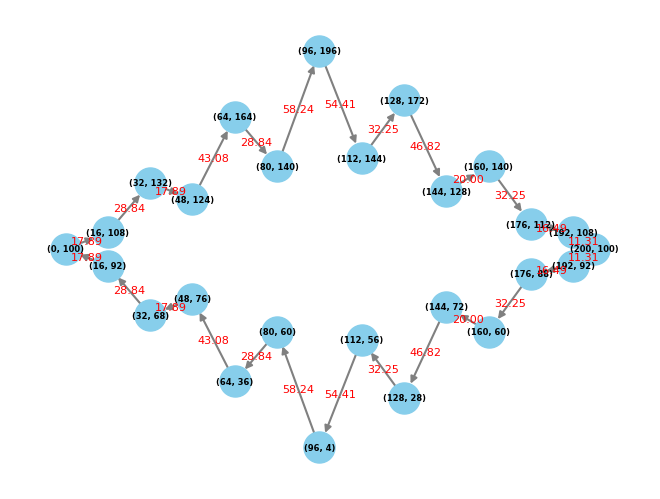

In [1]:
from utils_graph import generate_star_shaped_graph, plot_ordered_graph

vertices = generate_star_shaped_graph(num_nodes=12)
plot_ordered_graph(vertices)

## The problem
Let us assume that our list of vertices describes a complete graph. And our task is to find the shortest distance that visits each vertice exactly once. First, we randomize our current list. Then we plot the new path along with the complete graph to illustrate the complexity.

Total Distance: 2358.51


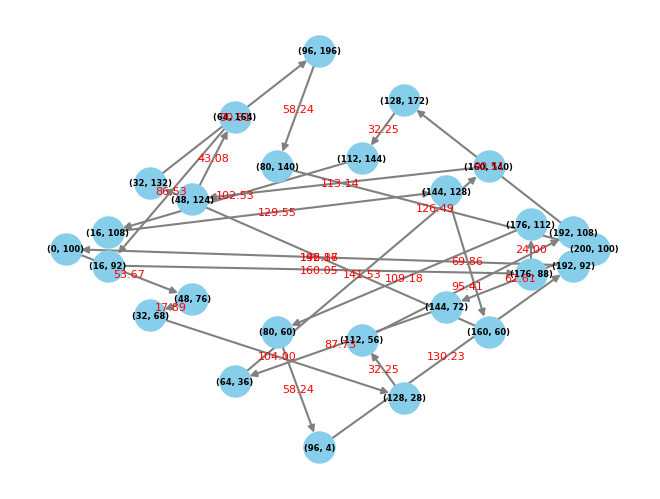

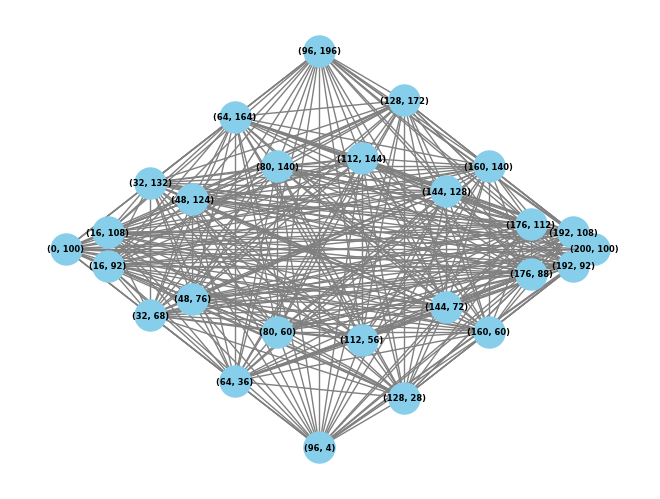

In [2]:
import random
from utils_graph import plot_complete_graph

random.shuffle(vertices)
plot_ordered_graph(vertices)
plot_complete_graph(vertices)

The distance of the randomized order is, unsurprisingly, a lot larger than the optimal distance. The complete graph also shows how the number of edges grows exponentially in relation to the number of vertices. Testing all possible paths is called an exhaustive search, and the time complexity is exponential (NP-hard).

## The Model

To address the problem of finding the shortest Hamiltonian path in a complete graph, we begin by defining our problem. Consider a graph $G$ consisting of $n$ vertices and $m$ edges.

### Graph Representation

The graph $G$ is complete, meaning that there is an edge between every pair of distinct vertices. This can be represented by an $ n \times n$ adjacency matrix $ A$, where $A[i][j]$ is 1 if there is an edge between vertex $i$ and vertex $j$, and 0 otherwise. Since the graph is complete,$ A[i][j] = 1$ for all $ i \neq j$.

### Hamiltonian Path

A Hamiltonian path is a path in the graph that visits each vertex exactly once and returns to the starting vertex, forming a cycle. In our case, we are interested in finding the shortest Hamiltonian path, i.e., the path with the minimum total edge weight - represented as distance.

### Objective Function

The objective is to minimize the total weight of the Hamiltonian path. This can be expressed as an objective function $f(P)$, where $P$ is a permutation of the vertices representing a potential Hamiltonian path. The objective is to find the permutation $P$ that minimizes $f(P)$.

### Decision Variables

The decision variables are the edges in the Hamiltonian path. We can use binary variables $x_{ij}$ to indicate whether the edge between vertices $i$ and $j$ is included in the path. The decision variable matrix $X$ is an $n \times n$ matrix, where $X[i][j] = 1$ if $x_{ij}$ is included in the path and 0 otherwise.

### Constraints

1. **Vertex Visit Constraints:** Each vertex must be visited exactly once in the Hamiltonian path. 
   $$
   \sum_{i=1}^{n} x_{ij} = 1 \quad \text{for } j = 1, 2, \ldots, n
   $$
   $$
   \sum_{j=1}^{n} x_{ij} = 1 \quad \text{for } i = 1, 2, \ldots, n
   $$
   $$
   x_{ij} = \{0,1\}
   $$

### Objective Function and Constraints

Combining the objective function and constraints, we can formulate the mathematical model for finding the shortest Hamiltonian path in a complete graph.


# Linear Programming & Linear Relaxation
Our model fits perfect for Linear Programming. As a matter of fact, Mixed Integer Programming (MIP) is an effecient method for solving TSP. In this case, I will use LP to achive an upper bound. We will break our constraint that $x_{i,j} = {0,1}, instead get a real number $x_{i,j} = [0,1]$. Since LP is not restricted to Integers, it will return a value(distance) that is either the optimal value or less: $LP(P) \leq f(P)$. 

Let us use Google ortools to get the linear relaxation (ortools implementation can be found in utils_optimization.py).

In [3]:
from utils_optimization import linnear_relaxation_tsp

_,solver,X = linnear_relaxation_tsp(vertices)
print("Objective value =", solver.Objective().Value())
values = []
for i in range(len(vertices)):
    for j in range(len(vertices)):
        if X[i,j].solution_value() > 0:
            print(X[i,j].name(), " = ", X[i,j].solution_value())
            values.append(((i,j), X[i,j].solution_value()))

Objective value = 645.4803071090971
x[0,21]  =  1.0
x[1,8]  =  0.9230769230769232
x[1,9]  =  0.07692307692307675
x[2,7]  =  0.03846153846153832
x[2,20]  =  0.9615384615384617
x[3,22]  =  0.9615384615384617
x[3,24]  =  0.03846153846153826
x[4,23]  =  0.9615384615384617
x[4,24]  =  0.03846153846153837
x[5,11]  =  0.038461538461538436
x[5,13]  =  0.038461538461538436
x[5,19]  =  0.9230769230769232
x[6,7]  =  0.9230769230769232
x[6,10]  =  0.07692307692307675
x[7,2]  =  0.03846153846153832
x[7,6]  =  0.038461538461538436
x[7,16]  =  0.9230769230769232
x[8,1]  =  0.038461538461538436
x[8,12]  =  0.03846153846153832
x[8,15]  =  0.9230769230769232
x[9,1]  =  0.9615384615384615
x[9,14]  =  0.038461538461538436
x[10,6]  =  0.9615384615384615
x[10,25]  =  0.038461538461538436
x[11,5]  =  0.9615384615384619
x[11,19]  =  0.0384615384615381
x[12,8]  =  0.038461538461538436
x[12,13]  =  0.9615384615384615
x[13,5]  =  0.038461538461538436
x[13,12]  =  0.9615384615384615
x[14,9]  =  0.9230769230769232

We got an objective value far less than the optimal value. This is expected since the we violate the constraint $x_{i,j} = {0,1}$. But the strength of this LP-algorithm is that it is fast. We can now use it for branching. Let us find a decisionvarable, $x_{i,j}$, with a value close to 0.5 - and branch on that variable.

In [4]:
differences = [(name, abs(val - 0.5)) for name,val in values]
x_to_branch, target_value = differences[0]
for x_next, value in differences[1:]:
    if value < target_value:
        x_to_branch = x_next
print("X to branch on is ", x_next)


X to branch on is  (25, 16)


In [5]:
from utils_optimization import add_lp_constraint, lp_tsp_branch, solve_lp
# Branch by setting x-value to 1
add_lp_constraint(solver, X, x_to_branch, 1)
_,solver = solve_lp(solver)
print(f"Objective value with X[{x_to_branch}] = 1", solver.Objective().Value())

# Branch by setting x-value to 0
# Build new model, ortools do not support solver to remove constraints
_,solver_new,X_new = lp_tsp_branch(vertices,[(x_to_branch,0)])
print(f"Objective value with X[{x_to_branch}] = 0", solver_new.Objective().Value())


Objective value with X[(25, 16)] = 1 645.6556931561598
Objective value with X[(25, 16)] = 0 646.0621810224577


## Compare the branch-values
Using the result from LP we now know what value to set $x_{ij}$, namely the value that gives the least value. We can now continue to pick the next undecided decision-variable to branch on. 

> Note: I use ortools in this notebook to showcase the theory on how to use LP to help with branch and bound (branch and cut), but the implementation is far from offiecent with the Python wrapper. There are exellent MIP-solvers that one can use instead.

Let us make a loop that continously use LP to get a feasable solution.

In [6]:
from utils_optimization import get_x_to_branch, add_lp_constraint, lp_tsp_branch, solve_lp
branch_choices = []
num_vertices = len(vertices)
included_vertices = 0
status,solver,X = lp_tsp_branch(vertices,branch_choices)

while included_vertices < num_vertices:
    print("decisions made: ")
    print(branch_choices)
    x_to_branch, _ = get_x_to_branch(X,num_vertices)
    if x_to_branch == 1:
        break
    # Check branch on x_ij = 1
    branch_include = (x_to_branch, 1)
    add_lp_constraint(solver, X, x_to_branch, 1)
    status_include, solver = solve_lp(solver)

    if status_include == 0:
        print(f"Objective value with X[{x_to_branch}] = 1", solver.Objective().Value())
    
    # Check branch on x_ij = 0
    branch_exclude = (x_to_branch, 0)
    branch_choices.append(branch_exclude)
    status_exclude,solver_new,X_new = lp_tsp_branch(vertices,branch_choices)

    if status_exclude == 0:
        print(f"Objective value with X[{x_to_branch}] = 0", solver_new.Objective().Value())
    
    if status_exclude == 0 and status_include == 0:
        # Compare the result and cut 
        if solver_new.Objective().Value() < solver.Objective().Value():
            solver = solver_new
            X = X_new
        else:
            branch_choices.pop()
            branch_choices.append(branch_include)
            included_vertices += 1
    elif status_exclude == 0:
        solver = solver_new
        X = X_new
    elif status_include == 0:
        branch_choices.pop()
        branch_choices.append(branch_include)
        included_vertices += 1
    else:
        print("Both failed.")
        break


decisions made: 
[]
Objective value with X[(25, 16)] = 1 645.6556931561598
Objective value with X[(25, 16)] = 0 646.0621810224577
decisions made: 
[((25, 16), 1)]
Objective value with X[(24, 4)] = 1 645.7689245207876
Objective value with X[(24, 4)] = 0 645.9294731348755
decisions made: 
[((25, 16), 1), ((24, 4), 1)]
Objective value with X[(23, 18)] = 1 653.5179915303959
Objective value with X[(23, 18)] = 0 645.8794327371245
decisions made: 
[((25, 16), 1), ((24, 4), 1), ((23, 18), 0)]
Objective value with X[(22, 19)] = 1 674.6128420803932
Objective value with X[(22, 19)] = 0 645.8794327371245
decisions made: 
[((25, 16), 1), ((24, 4), 1), ((23, 18), 0), ((22, 19), 0)]
Objective value with X[(20, 18)] = 1 668.2251842893835
Objective value with X[(20, 18)] = 0 646.4205942111626
decisions made: 
[((25, 16), 1), ((24, 4), 1), ((23, 18), 0), ((22, 19), 0), ((20, 18), 0)]
Objective value with X[(20, 7)] = 1 670.9962418497654
Objective value with X[(20, 7)] = 0 646.4205942111626
decisions mad

In [7]:
# Get edges

solution_edges = [0]
    
while len(solution_edges) < num_vertices:
    u = solution_edges[-1]
    for v in range(num_vertices):
        if X[u,v].solution_value() > 0:
            solution_edges.append(v)
            break
            
print(solution_edges)
print(vertices)
solution = []
for i in solution_edges:
    solution.append(vertices[i])
    
print(solution)

[0, 20, 2, 8, 15, 14, 9, 1, 22, 3, 23, 17, 18, 24, 4, 19, 11, 13, 12, 5, 10, 25, 16, 7, 6, 21]
[(144, 72), (64, 36), (160, 140), (48, 124), (64, 164), (16, 92), (176, 88), (176, 112), (80, 60), (96, 4), (192, 92), (0, 100), (48, 76), (32, 68), (128, 28), (112, 56), (192, 108), (128, 172), (112, 144), (16, 108), (144, 128), (160, 60), (32, 132), (96, 196), (80, 140), (200, 100)]
[(144, 72), (144, 128), (160, 140), (80, 60), (112, 56), (128, 28), (96, 4), (64, 36), (32, 132), (48, 124), (96, 196), (128, 172), (112, 144), (80, 140), (64, 164), (16, 108), (0, 100), (32, 68), (48, 76), (16, 92), (192, 92), (200, 100), (192, 108), (176, 112), (176, 88), (160, 60)]


## Check new solution
Our new solution is not the optimal. Let us plot it.

Total Distance: 1159.78


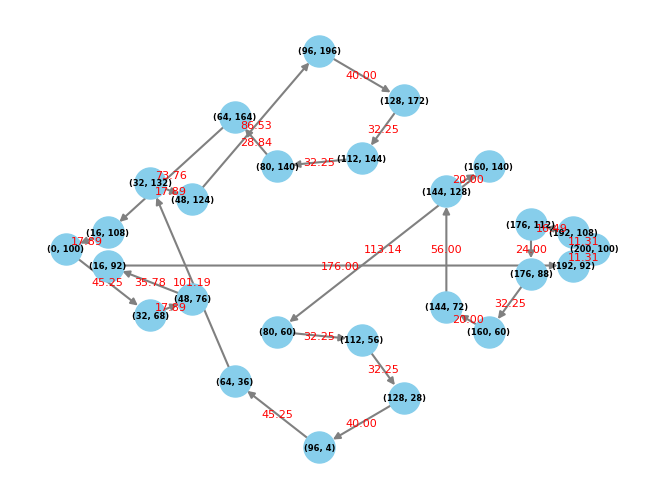

In [8]:
# Plot solution
plot_ordered_graph(solution)


It is however much greater than the randomized one. We now have an upper bound from LP and a lower bound from our latest solution. We know that the optimal solution is somewhere between. This can be done using exhaustive search.